# Set up wind farm run from NOW23 Neutral case

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
# Location of precursor run with boundary data
precursordir  = '/nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMCdemo_neutral1_10x10_20/'
precursorsetup= precursordir+'/abl_neutralMMC.inp'

# Location of farm run dir
farmrundir       = './MMCdemo_neutral1_farmrun1'
outputfile       = 'MMCdemo_Farmrun1_10x10_baseline.inp'
#'MedWS_LowTI_farmrun1.inp'
noturboutputfile = 'MMCdemo_Farmrun1_10x10_noturbs.inp'

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
if os.path.exists(farmrundir):
    shutil.rmtree(farmrundir)

os.makedirs(farmrundir)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [4]:
tstop  = 14400
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt', 0.02)
case.setAMRWindInput('time.max_step',  20050)

In [5]:
# Set the restart point
chkdir = precursordir+'/chk20000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [6]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics00000.nc'
tavg        = [10000, 14400]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg, 'bodyforce_file':'bforce.txt'}
inflowplanes= ['xhi', 'yhi'] 
bndryfiles  = precursordir+'/bndry_data'

case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_BodyForcing=False,
                           autoset_MMCForcing=True,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMCdemo_neutral1_10x10_20//bndry_data'
SET ABL_bndry_planes = ['xhi', 'yhi']
SET is_periodicx = False
SET is_periodicy = False
SET xhi_type = 'mass_inflow'
SET xhi_density = 1.177
SET xhi_temperature = 0.0
SET xhi_tke = 0.0
SET yhi_type = 'mass_inflow'
SET yhi_density = 1.177
SET yhi_temperature = 0.0
SET yhi_tke = 0.0
SET xlo_type = 'pressure_outflow'
SET xlo_density = None
SET xlo_temperature = None
SET xlo_tke = None
SET ylo_type = 'pressure_outflow'
SET ylo_density = None
SET ylo_temperature = None
SET ylo_tke = None
SET ABLForcing = False
Loading abl_meso_forcing_mom_x
Loading abl_meso_forcing_mom_y
SET BodyForce = True
SET BodyForce_type = 'height_varying'
Wrote bforce.txt
SET BodyForce_bodyforce_file = 'bforce.txt'
SET ABLMesoForcingMom = False
SET ABL_initial_condition_input_file = 'None'
SET ABL_mesoscale_forcing = 'None'
SET ABLMeanBoussinesq = True
SET wall_shear_stress_typ

In [7]:
case.setAMRWindInput('incflo.do_initial_proj', None)
case.setAMRWindInput('incflo.initial_iterations', None)

## Set the turbine locations

In [8]:
# Rotates a point pt about origin orig   
# Here theta is measured w.r.t. the x-axis
def rotatepoint(pt, orig, theta):
    dx = pt[0]-orig[0]
    dy = pt[1]-orig[1]
    p2=[0.0, 0.0]
    p2[0] = dx*math.cos(theta) - dy*math.sin(theta) + orig[0]
    p2[1] = dx*math.sin(theta) + dy*math.cos(theta) + orig[1]
    return p2

def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [9]:
# Define some properties
rotorD = 240           # Rotor diameter
WS     = 6.5           # Wind speed, m/s
WDir   = 15.965           # Wind direction, degrees

# Farm properties
farm_rotate      = -WDir                          # Number of degrees to rotate turbine rows (relative to x-axis)

# ==== 50 turbine staggered arrangement ====
farm_title       = 'IEA 15MW, 28 turbine staggered arrangement'
# Turbine spacing
turb_LatSpacing  = 6   # lateral spacing, diameters
turb_LongSpacing = 6   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':3, 'rowoffset':3},
               {'Nturb':3, 'rowoffset':3},
               {'Nturb':3, 'rowoffset':3},
              ]

farmturb_orig    = [4000, 6000]
farmL            = 5120.0
farm_domainsize  = [2*farmL, 2*farmL, 960.0]   # Farm domain size
farm_background_mesh = 20.0                     # Background mesh size [meters]

In [10]:
# Set the wind speed and direction
case.setAMRWindInput('useWSDir', True)                           # Allows you to specify wind speed + wind direction 
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)     # Wind speed of 9.03 m/s
case.setAMRWindInput('ABL_winddir',   WDir, forcechange=True)     # Wind direction of 225 degrees, from S-W
case.ABL_calculateWindVector()

In [11]:
# Build the wind farm turbine positions
farmturb_xy = []
for irow, row in enumerate(farmrowdict):
    turb_y = irow*turb_LongSpacing*rotorD
    for iturb in range(row['Nturb']):
        turb_x = iturb*turb_LatSpacing*rotorD + row['rowoffset']*rotorD
        farmturb_xy.append([turb_x, turb_y])
farmturb_xy = np.array(farmturb_xy)

print("Total turbines = "+repr(len(farmturb_xy)))

# Recenter the farm to be at the origin
farmturb_0 = np.mean(farmturb_xy, axis=0)
farmturb_xy = np.array([x-farmturb_0 for x in farmturb_xy])
farmturb_xy = np.array([rotatepoint(pt, [0.0, 0.0], farm_rotate*np.pi/180.0) for pt in farmturb_xy])
farmturb_xy = np.array([x+farmturb_orig for x in farmturb_xy])

Total turbines = 9


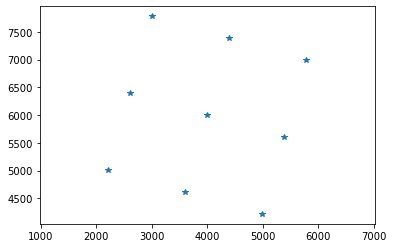

In [12]:
# Test plot
plt.plot(farmturb_xy[:,0], farmturb_xy[:,1], '*')
plt.axis('equal');

In [13]:
OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:0 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
           "ADparam_OutList0:RtAeroFxh "
           "EDparam_YawDOF:False "
           "EDparam_PtfmSgDOF:False "
           "EDparam_PtfmSwDOF:False "
           "EDparam_PtfmHvDOF:False "
           "EDparam_PtfmRDOF:False "
           "EDparam_PtfmPDOF:False "
           "EDparam_PtfmYDOF:False "
           "AMRparam_Actuator_epsilon:[2;2;2] "
           "AMRparam_Actuator_epsilon_tower:[2;2;2] "
          )
DISCON2p8_options = ("SDparam_DLL_FileName:/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so "
                     "SDparam_DLL_InFile:IEA-15-240-RWT-Monopile_DISCON_2p8.IN "
                    )

St         = 0.3
AWC_freq   = St*WS/rotorD
AWC_amp    = 1.0
AWCoptions = ("SD_param_Ptch_Cntrl:1 "
              "DISCONparam_AWC_Mode:1 "
              "DISCONparam_AWC_NumModes:1 DISCONparam_AWC_n:0 DISCONparam_AWC_freq:%f DISCONparam_AWC_amp:%f "%(AWC_freq, AWC_amp)
             )

# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, IEA15MW_ALM, , ,%s\n"
for iturb, xy in enumerate(farmturb_xy):
    turboptions  = OFoptions
    # uncomment this line for AWC
    #if iturb < 6:   turboptions += AWCoptions
    turbinescsv += rowformat%(iturb, xy[0], xy[1], turboptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [14]:
# Set up the domain 
case.setAMRWindInput('turbines_domainsize', farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_autocalccenter', False)
case.setAMRWindInput('turbines_farmcenter', [0, 0])
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_createnewdomain', False)

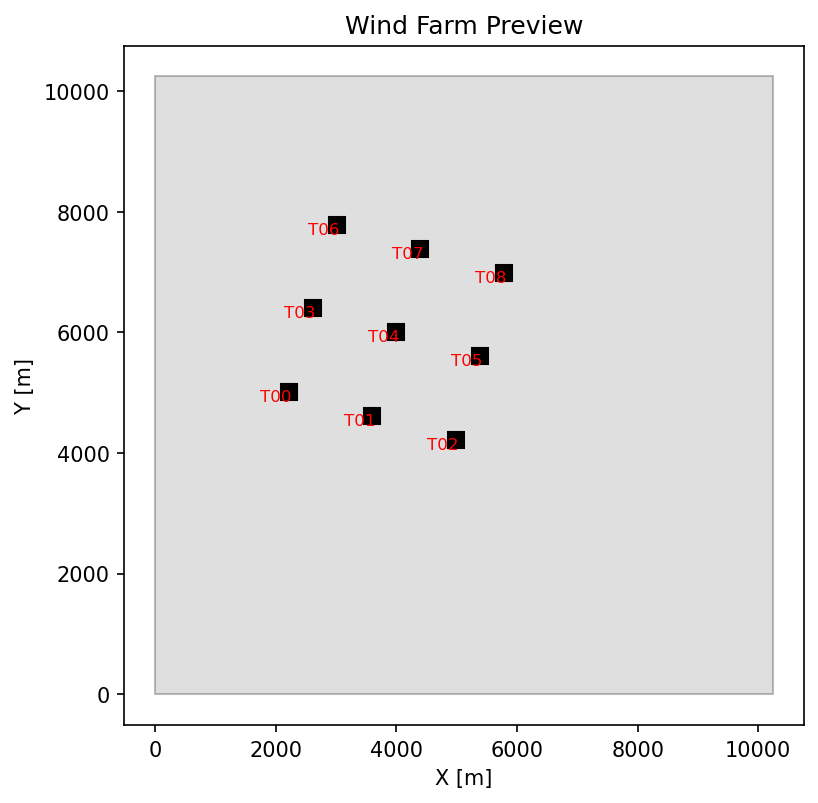

In [15]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [16]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T00_OpenFAST3p4_IEA15MW
T00_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T00_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T01_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T01_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T01_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T02_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T02_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T02_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T03_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T03_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T03_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T04_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T04_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T04_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T05_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T05_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T05_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T06_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T06_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T06_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T07_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T07_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T07_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST3p4_IEA15MW to T08_OpenFAST3p4_IEA15MW


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

T08_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMCdemo/MMCdemo_neutral1_farmrun1/T08_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.177000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08']


-105.96500000000003 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
     1.177 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) 

In [17]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,      2500,    2500,       3000,    150,   200,   center:specified units:meter centerx:4000 centery:6000 centerz:150 orientation:y name:A
#1,      2000,    2000,       2000,    150,   150,   center:specified units:meter centerx:4000 centery:6000 centerz:150 orientation:y name:B
0,     2250,     4000,       2250,    150,   200,   center:specified units:meter centerx:4000 centery:6000 centerz:150 orientation:{WDir} name:A
#1,     1750,     2000,       1750,    150,   150,   center:specified units:meter centerx:6000 centery:6000 centerz:150 orientation:{WDir} name:B
#0,     2,        3,          1.5,   0.625,   2,     orientation:nacdir

1,     1.2,      1.2,        1.0,   0.625,   1.5,   orientation:nacdir
2,     0.6,      0.60,       0.75,  0.625,   0.625, orientation:nacdir
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv.format(WDir=WDir))
case.setAMRWindInput('refine_deleteprev', True)
case.refine_createAllZones()

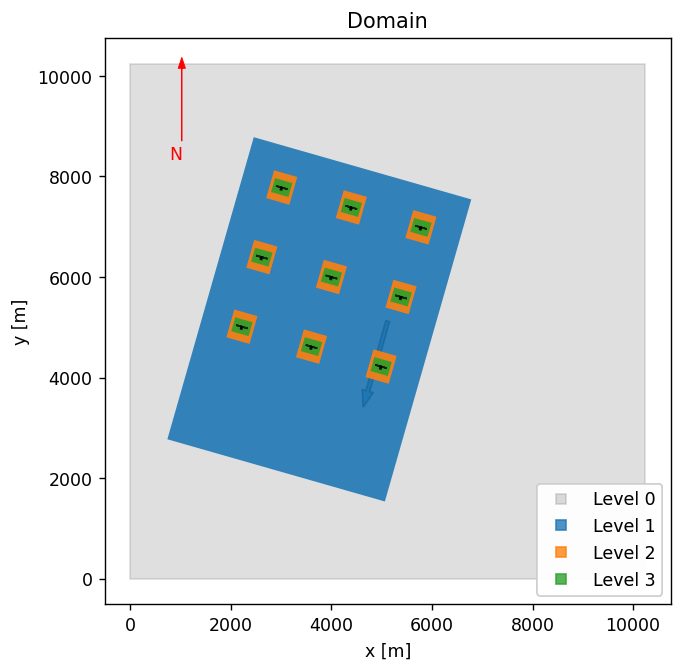

In [18]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)

In [19]:
# This will print out your mesh size & refinements
case.estimateMeshSize()

Refinement A: level 1: 9843750 cells
Refinement T00_level_1_zone: level 2: 1128038 cells
Refinement T01_level_1_zone: level 2: 1128038 cells
Refinement T02_level_1_zone: level 2: 1128038 cells
Refinement T03_level_1_zone: level 2: 1128038 cells
Refinement T04_level_1_zone: level 2: 1128038 cells
Refinement T05_level_1_zone: level 2: 1128038 cells
Refinement T06_level_1_zone: level 2: 1128038 cells
Refinement T07_level_1_zone: level 2: 1128038 cells
Refinement T08_level_1_zone: level 2: 1128038 cells
Refinement T00_level_2_zone: level 3: 1990656 cells
Refinement T01_level_2_zone: level 3: 1990656 cells
Refinement T02_level_2_zone: level 3: 1990656 cells
Refinement T03_level_2_zone: level 3: 1990656 cells
Refinement T04_level_2_zone: level 3: 1990656 cells
Refinement T05_level_2_zone: level 3: 1990656 cells
Refinement T06_level_2_zone: level 3: 1990656 cells
Refinement T07_level_2_zone: level 3: 1990656 cells
Refinement T08_level_2_zone: level 3: 1990656 cells
ESTIMATED MESH SIZE
   Leve

## Add sampling planes

In [20]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [21]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:25"

turbsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type,       upstream, downstream, lateral, below, above, n1, n2, options
turbhh,    hubheight,  5,        5,         2,       0,     1.5,     11, 11, usedx:0.05 outputto:turbhh_ orientation:nacdir {outputoptions} noffsets:1
sw,        streamwise, 5,        5,         0,       0.625, 1.5,     11, 11, usedx:0.05 outputto:turbsw_  orientation:nacdir {outputoptions}
rotor,     rotorplane, 5,        5,         2,       0.625, 1.5,     11, 11, usedx:0.05  outputto:rotor_   orientation:nacdir outputvars:velocity noffsets:10  {outputoptions}

swdomain,  streamwise, 8,        8,         6,       0.625, 1.5,     11, 11, usedx:0.1  outputto:swdomain_ orientation:nacdir  center:specified centerx:6000 centery:6000 centerz:150 wholedomain:1 {outputoptions}
turbdomain,hubheight,  8,        8,         2,       0,     1.5,     11, 11, usedx:0.1  outputto:turbdomain_ orientation:nacdir center:farm wholedomain:1  {outputoptions} noffsets:1
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', turbsamplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [22]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['T00_turbhh', 'T01_turbhh', 'T02_turbhh', 'T03_turbhh', 'T04_turbhh', 'T05_turbhh', 'T06_turbhh', 'T07_turbhh', 'T08_turbhh', 'T00_sw', 'T01_sw', 'T02_sw', 'T03_sw', 'T04_sw', 'T05_sw', 'T06_sw', 'T07_sw', 'T08_sw', 'T00_rotor', 'T01_rotor', 'T02_rotor', 'T03_rotor', 'T04_rotor', 'T05_rotor', 'T06_rotor', 'T07_rotor', 'T08_rotor', 'Farm_swdomain', 'Farm_turbdomain']


### Plot the domain

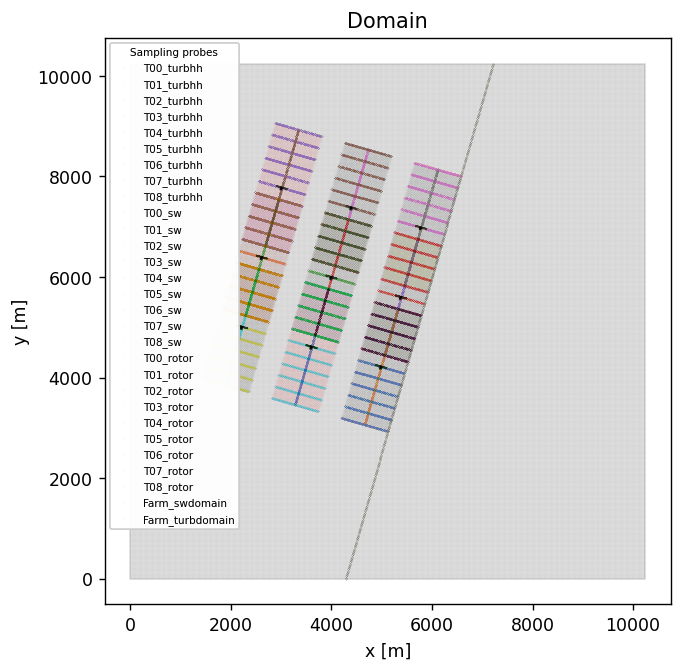

In [23]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':0.01, 'marker':'.', 'linestyle':'None','alpha':0.25, }"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend']= "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper left', 'markerscale':10}"
case.plotDomain(ax=ax)

Text(0.5, 1.0, 'Initial Temp. Profile')

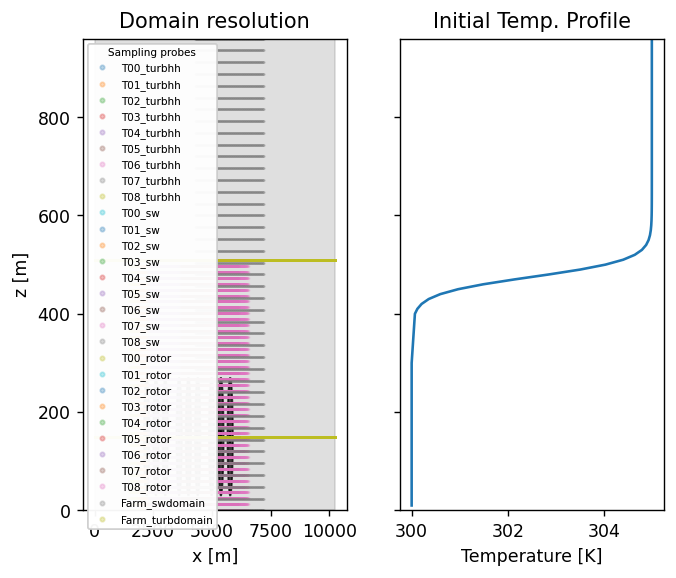

In [24]:
fig, axs = plt.subplots(1,2, figsize=(6,5), facecolor='w', dpi=125, sharey=True)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ' 
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':0.5, 'marker':'.', 'linestyle':'None','alpha':0.25}"
case.plotDomain(ax=axs[0])
axs[0].set_title('Domain resolution')
axs[0].axis('auto')
axs[0].set_ylim([0,960])

case.plotGenericProfile('ABL.temperature_values', 'ABL.temperature_heights', ax=axs[1])
axs[1].set_ylim([0,960])
#axs[1].axis('scaled')
axs[1].set_xlabel('Temperature [K]')
axs[1].set_title('Initial Temp. Profile')

In [25]:
# Check that all inputs are okay
check=case.validate()

-- Checking inputs --
[ PASS] max_level:           max_level = 3 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] restart dir:         Restart directory /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMCdemo_neutral1_10x10_20/chk20000 exists
[ PASS] boundary plane dir:  Restart directory /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMCdemo_neutral1_10x10_20//bndry_data exists
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ PASS] Actuator FST:T00     [T00_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst] exists
[ PASS] Actuator FST:T00     Actuator density=1.177000, matches incflo.density=1.177000
[ PASS] Actuator FST:T00     CompInflow OK
[ PASS] Actuator FST:T00     [T00_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_AeroDyn15.dat] exists
[ PASS] Actuator FST:T00     WakeMod=0 OK
[ PASS] Actuator FST:T00     AirDens=1.177000, matches incflo.density=1.177000
[ PASS] Actuator FST:T01   

In [26]:
print(case.writeAMRWindInput(outputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 14400.0             # Max (simulated) time to evolve [s]
time.max_step                            = 20050               
time.fixed_dt                            = 0.02                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 1000                
time.checkpoint_start                    = 20000               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMCdemo_neutral1_10x10_20/chk20000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model            

In [27]:
# Write no turbine version
# Create a version without turbines
case.removeturbines()
#case.setAMRWindInput('amr.max_level',0)
inputfile=case.writeAMRWindInput(noturboutputfile)